# Basics of Electoral Bias Measures

*Levi John Wolf<br>
University of Bristol<br>
levi.john.wolf@gmail.com<br>
(Supported by NSF #1657689)*

So far, we have learned quite a bit about the structural models of elections that model the expected wins a party has in the legislature as a function of how well they do in an election. These *seats-votes* models are fundamental to many different kinds of electoral bias measures. To this point, we've talked about electoral bias a *specific parameter* in a given model of the seats-votes curve (see Chapter 00 in the discussion of the Cube Rule & the Log-Odds election model). This works when we state a specific model for the seats-votes curve that provides a "bias" parameter, but many of the methods (including the simple bootstrap method we've been using so far) do not admit a direct parameter that measures the "bias" of a given seats-votes curve. 

So, how can we measure bias? Well, using the simulations from something like the seats-votes curve estimators, we can obtain nearly any measure of bias. Further, armed with a simulator, we can also get somewhat reasonable estimates of uncertainty about the bias (so long as we have confidence that the simulated elections actually represent *realistic* scenarios that might actually be experienced in elections). This notebook will walk through three fundamental ideas in the estimation of "partisan bias," and will talk about four measure of partisan bias, including:

1. partisan symmetry
2. mean-median discrepancy
3. attainment gaps
4. efficiency gaps

First, though, like before, we'll need to import some of the Python packages necessary to do the data processing, plotting, and mathematics:

In [1]:
import seatsvotes
import numpy
import pandas
from scipy import stats
numpy.random.seed(111211)

import matplotlib.pyplot as plt

%matplotlib inline

This time, we'll use the same example data set provided in the `seatsvotes` package:

In [2]:
df = seatsvotes.data.congress(geo=True)

And focus only on the state of Illinois:

In [3]:
data = df[df.state_name.str.match('illinois')]

Then, we'll fit the same Bootstrap-style estimator:

In [4]:
boot = seatsvotes.Bootstrap(data, district_id='lewis_dist')

/home/lw17329/Dropbox/dissert/dev/seatsvotes/seatsvotes/utils.py:143: UserWarning: computing redistricting from years vector
  warn('computing redistricting from years vector')
/home/lw17329/anaconda/envs/ana/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


And, for visualization purposes, show what the estimated seats-votes curve looks like below:

Text(0.5,1,'Seats Votes Curve, IL 2010')

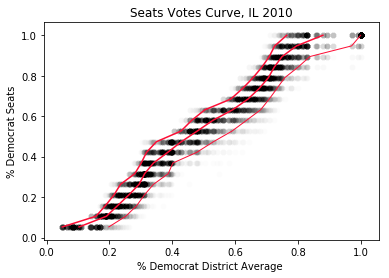

In [5]:
boot.plot_simulated_seatsvotes(year=2010, n_sims=1000)
plt.xlabel('% Democrat District Average ')
plt.ylabel('% Democrat Seats')
plt.title('Seats Votes Curve, IL 2010')


Now, many measures of partisan bias focus on this curve. In general, these measures tend to compare the difference in shape between this curve and some *idealized* version of this curve that represents a fair relationship between the seats a party wins in a congressional delegation and its performance in the election. Further, many measures also have a specific reference to a given ethical question, statement, or principle that is considered to be indicative of "fairness" in an electoral system. Thus, we will discuss these concepts for a few common partisan bias measures. Specifically, we'll cover the four bias measures we mention in the introduction, starting with the most commonly-accepted concept, partisan symmetry. 



# Basic Partisan Symmetry

The core concept & main idea of partisan symmetry focuses on ensuring parties with similar popular support achieve similar levels of government control. Stated explicitly:

> parties with similar levels of popular support should be given similar levels of representation in Congress

At its core, then, this means that two parties that recieve the same average district vote share should probably also get a similar number of seats in Congress. Since the seats-votes curve proides a prediction of how many seats a party wins as a function of the average district vote share, partisan symmetry measures can assess the asymmetry between the fraction of seats in congress a party wins and their average level of support in districts across the country. In a two-party system like the US, partisan symmetry can be assessed in either of the following scenarios:

1. Party A wins $s\%$ of the Congress when they win $h\%$ average district vote share. When party B wins $h\%$ average district vote share, does party B also win $s\%$ of the Congress?
2. Party A and Party B have equivalent average district vote shares, $h\% = (100-h)\% = 50\%$. Do party A and party B win the same number of seats? 

In a strict sense, it's *always* easier to analyze the second scenario than the first. Say Democrats win an average of 44% of the vote in each district. Scenario 1 requires that we construct a prediction about what would happen when Dems win $100-44 = 56\%$ on average. This prediction is $12\%$ away from the reality we *did* observe, where Dems won $44\%$. But, using scenario 2, we only have to create a prediction of what happens when Dems and Republicans both get 50% of the vote. This is a scenario that's only $6\%$ away from the case we did observe. Thus, it's a **much** smaller extrapolation than the one that requires us to predict what happens under a $12\%$ swing. Thus, it's simpler and more effective for analysts to consider what happens when both parties recieve an equivalent percent of the vote. 

*(As an aside, in my dissertation, I interviewed officials who worked for the nonpartisan redistricting commissions in both Washington and Arizona. Both groups of participants agreed that scenario 2 is realistic in their home states, but that scenario 1 is unlikely. That is, they said it was indeed possible for parties to win about the same average percentage vote in districts, but they thought it highly improbable that the state would **flip** from one party to the same split for the other party. Thus for both methodological and validity reasons, it's better to analyze scenario 2 than 1.)*

Focusing on the area of the seats-votes curve near where both parties would win 50% on average:

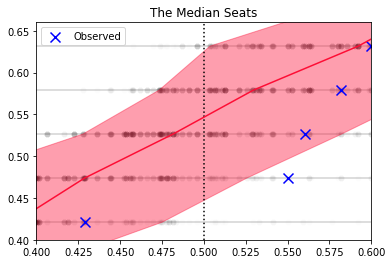

In [6]:
f,ax,sims,ranks = boot.plot_simulated_seatsvotes(year=2010, n_sims=1000, 
                                                 band=True, silhouette=True,
                                                 return_sims=True)
n_districts = sims[0].shape[0]
boot.plot_empirical_seatsvotes(year=2010, 
                               scatter_kw=dict(marker='x', s=100,
                                               color='blue', label='Observed'), 
                                ax=ax)

win_the_delegation = numpy.hstack([sim[numpy.where(rank==4)] 
                            for sim,rank in zip(sims,ranks)])

ax.hlines(numpy.arange(0,n_districts+1)/n_districts,
          0,1, color='lightgrey', zorder=-1)
plt.vlines(.5,0,1, linestyle=':')
ax.set_ylim(.4, .66)
ax.set_xlim(.4,.6)
ax.set_title('The Median Seats')
ax.legend()
plt.show()

From this, we can see that, when both parties win 50% on average, Democrats tend to win one seat below a majority, or they tend to win one or two seats above a majority. But, we really want to hone in on the replications where Democrats & Republicans win nearly the same average district vote share. Simply looking in aggregate is not enough. To do this, we can see the full distribution of Democrat average voteshares for each simulation, and highlight the band where simulations have Democrats winning between 49.5% & 50.5% district average voteshare on average:

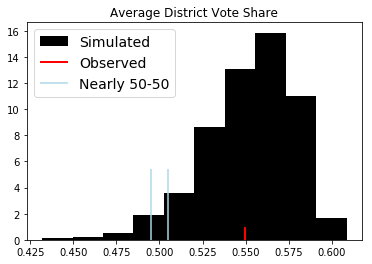

In [7]:
plt.hist(sims.mean(axis=1), density=True, color='k', label='Simulated')
plt.title('Average District Vote Share')
plt.vlines(boot.wide[-1].vote_share.mean(), 0,1, color='r', linewidth=2, label='Observed')
plt.vlines((.495,.505), 0,5.4, color='lightblue', label='Nearly 50-50')
plt.legend(fontsize=14)

As we'd expect, most of the simulations cluster at or around the observed average vote share for Democrats, about 55%. But, we need to focus on simulations where Democrats and Republicans both win about 50% of the vote in districts, on average. Thus, we will cut out all the simulations where the average district vote share falls in 49.5% & 50.5%:

In [8]:
nearly_even = numpy.abs(sims.mean(axis=1) - .5) < .005

There are only a few simulations that fall within this range:

In [9]:
nearly_even.sum()

19

We can artificially inflate this number using a few numerical tricks, but we'll focus on the raw results without them for now. Assuming that results are functionally the same when observations are between 49.5 & 50.5, we first get the percent of the congress Dems win when they get between 49.5 and 50.5% in districts on average:

In [10]:
dem_wins_in_even_elex = sims[nearly_even] > .5
dem_seatshares_in_even_elex = dem_wins_in_even_elex.mean(axis=1)

Breaking this down by the number of simulations where dems win a given fraction of seats, we see the following distribution for simulations that fall within 49.5% and 50.5%:

In [11]:
fractions, counts = numpy.unique(dem_seatshares_in_even_elex, return_counts=True)
print('Simulations with Democrat District \nAverage Vote between 49.5% & 50.5%')
pandas.DataFrame({'Dem Wins':fractions, 'N Sims':counts})

Simulations with Democrat District 
Average Vote between 49.5% & 50.5%


,Dem Wins,N Sims
0,0.368421,1
1,0.421053,2
2,0.473684,5
3,0.526316,10
4,0.578947,1


Thus, on average, there's around 11 simulations where the Dems win a majority in congress and 8 simulations where Dems fail to win a majority in Congress when parties achieve about the same percentage of the average district vote share. On average, then, Dems win:

In [26]:
print('{:.2f} percent'.format(dem_seatshares_in_even_elex.mean()*100))

49.58 percent


of the seats in the Illinois congressional delegation when they win the same vote share in districts as Republicans. Thus, you can say the system is biased *very slightly* against Democrats in Illinois congressional elections, but the size of this bias is so small that it's unlikely to be practically significant under any meaningful criteria of interpretation. 

# One Alternative: the Mean-Median Gap

Related to ideas about partisan symmetry, the mean-median gap is another way that we can characterize the structure of bias. The measure focuses on the fact that the *median* district in each simulation is the district which splits the congressional delegation 50-50. If a party tends to need a lot more votest to get 50% of the congressional delegation, then the system may be biased against that party. Thus, the gap between the mean district and the median district provides an indication of the discrepancy between the votes required to win 50% of the seats in a delegation and the average votes that the party tends to win. 

For example, let's focus on the 2010 election:

In [12]:
observed_vote = boot.wide[-1].vote_share.values

In this election, Democrats had an average district vote share of:

In [27]:
observed_vote.mean()

0.5496400662151846

but had a median vote share of:

In [29]:
numpy.median(observed_vote)

0.489195329669053

So, this suggests that Democrats only needed 48% on average in districts to win a bare majority of the Illinois congressional delegation. But, they actually won 54% of the vote. Thus, there are many heavily Democratic districts which skew the distribution of Democrat district vote shares. With this skew, Dems tend to win more votes in districts than they would really need to in order to win a majority of the congressional delegation. Thus, their votes are wasted, and the system is biased subtly (again) towards Republicans in Illinois.

In general, we can look at this in each simulation, and we'll see that in the simulations, we get a small bias *towards* Democrats, but there's so much variability around this that there's no distinguishable bias either way. 

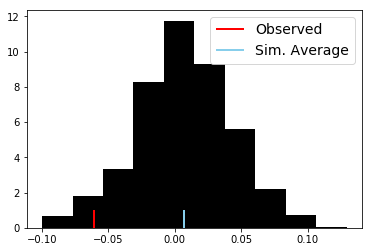

In [36]:
plt.hist(numpy.median(sims, axis=1) - numpy.mean(sims, axis=1), 
         density=True, color='k')
plt.vlines(numpy.median(observed_vote) - numpy.mean(observed_vote), 0,1,
           color='r', linewidth=2, label='Observed')
plt.vlines(numpy.mean(numpy.median(sims, axis=1) - numpy.mean(sims, axis=1)), 0,1, 
           color='skyblue', linewidth=2, label='Sim. Average')
plt.legend(fontsize=14)
plt.show()

# Another Alternative: minimum attainment

In a similar fashion, an attainment gap considers the difference in the voteshares Dems or Republicans need to get a majority of the congressional delgation. That is, we build the average district vote share for when Democrats win the congressional delegation & for when Republicans win the congressional delegation. Then, we look at the average district vote share for times when Republicans win and when Democrats win. Basically, this shows how "difficult" it is for a party to win a majority of the delegation or legislature under study. If Republicans tend to need *way* higher average vote share than Democrats, then it's harder on average for them to win control. Computing this directly, we first grab the simulations where Democrats & Republicans win:

In [50]:
dems_win = (sims > .5).sum(axis=1) > (n_districts * .5)
reps_win = (sims < .5).sum(axis=1) > (n_districts * .5)

And then get the average vote share *Democrats* recieve in both of these scenarios *(We'll convert the Republican wins to Republican vote shares later, to avoid confusion)*.  

In [51]:
average_dem_wins = sims[dems_win].mean(axis=1)
average_rep_wins = sims[reps_win].mean(axis=1)

First, though, we can see the distributions of average voteshares for when each party wins control:

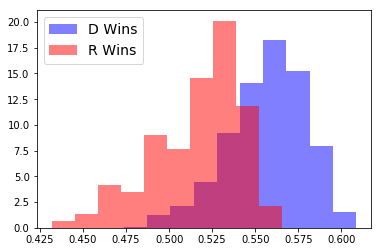

In [61]:
plt.hist(average_dem_wins, color='b', alpha=.5, density=True, label='D Wins')
plt.hist(average_rep_wins, color='r', alpha=.5, density=True, label='R Wins')
plt.legend(fontsize=14)
plt.show()

Thus, in general, we see that Democrats tend to win more than 50% of the vote *regardless* of which party wins control of the congressional delegation. This means that the attainment gap in Illinois is rather large, around 7%:

In [62]:
(1-average_rep_wins).mean(), average_dem_wins.mean()

(0.483596289305476, 0.5567569194014055)

This can also be assessed using a distributional distance measure, like Cohen's $d$:

In [79]:
n1, = average_dem_wins.shape
n2, = average_rep_wins.shape
div = (average_dem_wins.mean() - average_rep_wins.mean())
disp = ((n1-1)*average_dem_wins.var() + (n2 - 1)*average_rep_wins.var()) / (n1 + n2 - 2)
print("Cohen's d for difference in Democrat & Republican wins: {:.2f}".format(div/(disp**.5)))

Cohen's d for difference in Democrat & Republican wins: 1.77


This is pretty large, suggesting that there's a substantial difference between the average vote shares in simulations where Democrats tend to win and those where Republicans tend to win. Further, this suggests that Democrats need way more votes to win a majority of the congressional delegation than Republicans (on average).

# Another Alternative: Efficiency Gap

The attainment gap relates conceptually this next estimate of partisan bias, the *efficiency gap*. The efficiency gap is related to the attainment gap, but considers the *turnout* in districts. Thus, it's often stated as the percentage difference in *wasted votes* between seats a party wins versus seats a party loses. Altogether, this is a *seat-level* attainment measure, whereas the attainment measure noted above is a *delegation-level* attainment measure. Together, they both provide a direct measurement of how much easier (or more difficult) it is for a party to win seats; this is unlike the symmetry measures, which only provide an expectation of the wins or losses in a hypothetical scenario. 

It's this reason attainment-style measures have been more recently favored in legislation and jurisprudence. Specifically the efficiency gap has seen popular adoption, and is one measure that is gaining significant public attention in addition to academic interest. It is important to note, however: the same thing happened for partisan symmetry measures around the *Bandemer v. Davis (1984)* decision, as well as the *LULAC v. Perry (2006)* decision. 

In order for us to examine efficiency gaps, we need the observed turnout:

In [80]:
turnout = boot.wide[-1].turnout.values[None,::]

Then, the efficiency gap is built from the *raw votes* that are wasted by parties. The efficiency gap considers two kinds of votes as "wasted":

1. votes cast for a candidate that loses. These can be called *losing votes*, and are all votes cast for the party that loses the district. 
2. votes cast for a candidate that wins, but aren't needed for that candidate to win. These can be called *excess votes*, and are all votes past the 50%+1th vote that the candidate gets in order to win election. 

Thus, the total waste for party *A*, called $w_A$, is the sum of losing & excess votes. The efficiency gap is the difference in waste, divided by the total turnout, $N_v$:

$$ \frac{w_{A} - w_{B}}{N_{v}} $$

If the system tends to favor party $A$, the gap is negative, since party $B$ has a higher waste than party $A$. In general, we can compute this by building the losing & excess votes for each party:

In [81]:
dem_in_excess_of_victory = (turnout * (sims - .5) * (sims > .5)).sum(axis=1)
dem_for_losers = (turnout * sims * (sims < .5)).sum(axis=1)

In [102]:
rep_in_excess_of_victory = (turnout * ( (1-sims) - .5) * ((1-sims) > .5) ).sum(axis=1)
rep_for_losers = (turnout * (1-sims) * ((1-sims) < .5) ).sum(axis=1)

And then their total waste is the sum of the excess and losing otes:

In [103]:
dem_waste = dem_in_excess_of_victory + dem_for_losers
rep_waste = rep_in_excess_of_victory + rep_for_losers

Building the empirical waste is also possible using the same steps:

In [96]:
empirical_dem_eovs = ((observed_vote > .5) * (observed_vote - .5) * turnout).sum()
empirical_dem_lost = ((observed_vote < .5) * (observed_vote) * turnout ).sum()
empirical_dem_waste = empirical_dem_eovs + empirical_dem_lost

empirical_rep_eovs = (((1-observed_vote) > .5) * ((1-observed_vote)- .5) * turnout).sum()
empirical_rep_lost = (((1-observed_vote) < .5) * (1-observed_vote) * turnout ).sum()
empirical_rep_waste = empirical_rep_eovs + empirical_rep_lost

And, finally, we grab the difference in the wastes and divide by the total number of votes cast across all districts. Together this provides an indication of what percentage of the system overall is wasted, and gives a measure of whether Republicans or Democrats tend to waste more. Again, recall that if the statistic is stated:

$$ \frac{w_{D} - w_{R}}{N_{v}} $$

Then a positive efficiency gap will indicate bias *against Democrats*, since their waste tend to be larger than Republicans. Below, we'll see the *observed* and *simulated* gap for Illinois, suggesting again that the Illinois system is slightly biased against Democrats. Here, though, the power of turnout shows through: in general, over 80% of the simulations suggest that the efficiency gap shows bias against Democrats. While this wouldn't rise to a classical *pseudo*-significance level used in typical social science, this is not necessarily the correct comparison for this application. Thus, we'll take this as weak evidence that, even in cases of random re-swinging of votes, there tends to be a slight anti-Democrat bias in Illinois for the 2010 elections (and, thus, the 2000 districting plan). 

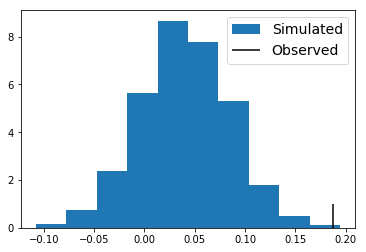

In [107]:
plt.hist(, density=True, label='Simulated')
plt.vlines((empirical_dem_waste - empirical_rep_waste)/turnout.sum(), 0,1, label='Observed')
plt.legend(fontsize=14)
plt.show()

What this *does not* suggest is that the districts are *gerrymandered* against Democrats; bias itself is a necessary result of gerrymandering, but not *sufficient to demonstrate gerrymandering*!

# Conclusion

Gerrymandering is a complicated topic, and many different measures of partisan bias exist. These measures tend to focus on specific, estimated quantities about the electoral system. In general, any method that can construct a *seats-votes* curve, like the ones provided in the Python package `seatsvotes`, can be used to estimate these measures of bias. 

That said, many of the measures of partisan bias operationalize what *fairness* is in different ways. Measures of attainment tend to focus on how *easy* it is for a party to win control of a seat or of an entire congressional delegation. Measures of *symmetry* tend to focus instead on the parity in the number of seats parties tend to win when they win similar levels of popular support. In general, measures can disagree with one another, since they all reflect slightly different ways of thinking about and representing partisan bias. However, in my empirical studies in my dissertation, the measures all tend to agree with one another in nearly all cases; situations where measures *disagreed* even within a single simulation were incredibly rare, but do indeed arise

Finally, empirical measurement of bias does *not* account for other structural factors like incumbency or racially-polarized voting, so it's important not to leap directly from 

> there is slight bias against party $A$

to 

> the system is *gerrymandered* against party $A$


The most critical component of using electoral bias measures is to *attempt* to control for these factors and measure the resulting bias *over and above* that accounted for by other factors. Incumbent gerrymandering & racial gerrymandering *are not* partisan gerrymandering, although they may intersect and obscure our ability to estimate one or the other's size, strength, or significance. In practice, models tend to get around these concerns about other kinds of gerrymandering by *attempting* to estimate the size of incumbent advantage & racial voting, and then constructing simulations where these factors *are not present*. The method used so far, bootstrapping, attempts to control for this by randomizing the extent to which *observed* incumbent or racial factors are assigned to specific districts. That said, no method is perfect. In the following chapters, I demonstrate how to use a few of these methods implemented in `seatsvotes` to simulate seats-votes curves under controlled (or random) conditions. 